In [1]:
import pandas as pd
from pathlib import Path
import xarray as xr
import re
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from xhistogram.xarray import histogram as xhist
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import dask
import dask.array as da
from dask.distributed import Client, wait
import dask.bag as db
from matplotlib.colors import BoundaryNorm

ERROR 1: PROJ: proj_create_from_database: Open of /srv/conda/envs/notebook/share/proj failed


In [2]:
release_stations_file = '/gxfs_work/geomar/smomw523/2022_north-sea_oysters/data/config/stations.csv'
output_path = '/gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/revision'

In [3]:
stations = pd.read_csv(release_stations_file, delimiter="\t")['site_id'].tolist() # read all stations from csv
years = [2019,2020,2021,2022] # years from expreiment run
offsets = np.char.zfill(np.arange(123).astype(str), 3)

In [4]:
def read_traj_file(file): # open all output data and create coordinates (year, station, ...) out of output name
    ds = xr.open_dataset(file) #, chunks={"traj": 1_000, }
    year = int(re.findall("\d{4}" ,file.name)[1])
    offset = int(re.findall("\d{3}" ,file.name)[2]) #not the nicest syntax?
    release_zone = re.findall(".{7}" ,file.name)[0]
    #release_depth = re.findall("(?<=depth-)\d+" ,file.name)[0]
    ds["year"] = xr.full_like(ds.lon.isel(obs=0, drop=True), year, int).load()
    ds["offset"] = xr.full_like(ds.lon.isel(obs=0, drop=True), offset, int).load()
    ds["release_zone"] = xr.full_like(ds.lon.isel(obs=0, drop=True), release_zone, np.object_).load()
    #ds["release_depth"] = xr.full_like(ds.lon.isel(obs=0, drop=True), release_depth, np.object_).load()
    ds = ds.drop(["trajectory", ])
    return ds

In [5]:
# area as line integral (Green's Theorem)

def area(vs):
    a = 0
    x0,y0 = vs[0]
    for [x1,y1] in vs[1:]:
        dx = x1-x0
        dy = y1-y0
        a += 0.5*(y0*dx - x0*dy)
        x0 = x1
        y0 = y1
    return a

In [6]:
# Parallelize processes

#client = Client(n_workers=8, threads_per_worker=4, memory_limit=32e9, ip="0.0.0.0")
client = Client(scheduler_file="/gxfs_work/geomar/smomw523/2022_north-sea_oysters/scheduler.json")
client.restart()
client

<Client: 'tcp://10.0.6.44:8786' processes=40 threads=160, memory=1.16 TiB>

### calculate spread areas, < 40 m

In [7]:
heatmaps_file = '/gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/combined_heatmap_individual-offset/all_heatmaps.nc'

In [8]:
### 100 %

areas = []
stationarea = []
yeararea = []

def process_station_year(task):
    station, year, offset = task # read the data separately for each station
    try:
#        output_files = sorted(Path(output_path).glob(f"{station}*ref-{year}*offset-{offset}*10000_depth-4m_seed-12345.nc"))
#        output_datasets = xr.concat(map(read_traj_file, output_files), dim="traj");
#        ds = output_datasets.set_coords(["year", "release_zone"])
#        ds = ds.isel(obs=slice(0,48))
#        ds = ds.where(ds.topography<40, drop=True)
        
#        output_files = sorted(Path(output_path).glob(f"{station}*10000_depth-4m_seed-12345.nc")) #*ref-{year}
#        output_datasets = xr.concat(map(read_traj_file, output_files), dim="traj");
#        ds = output_datasets.set_coords(["year", "offset", "release_zone"])
            
#        # high resolution bins to create a heatmap
#        dlon = 0.015
#        dlat = 0.01

#        lons = np.arange(lon_min - dlon, lon_max + 2 * dlon, dlon)
#        lats = np.arange(lat_min - dlat, lat_max + 2 * dlat, dlat)
    
#        # create heatmap
#        heat_map = xhist(ds.lon, ds.lat, bins=[lons, lats], dim=["traj", ])
#        heat_map = heat_map.where(heat_map > 0).sum(dim='obs') #sum over total runtime
#        heat_map = heat_map.compute()
 

###### Either process heatmaps again from the trajectories or read in the combined heatmap dataset ######
    
        heat_map_ds = xr.open_dataset(heatmaps_file)
        heat_map = heat_map_ds.sel(station = station, year = str(year), offset = offset,
                                   period="0-2", # choose period from 0-2, 0-28 or 14-28 days after release
                                  ).particle_number
        
###### Either process heatmaps again from the trajectories or read in the combined heatmap dataset ######
    
        # convert lon lat axis to km
        lattokm = np.linspace(0,(heat_map.lat_bin.max()-heat_map.lat_bin.min())*110.574,len(heat_map.lat_bin))
        lontokm = np.linspace(0,(heat_map.lon_bin.max()-heat_map.lon_bin.min())*111.320*np.cos(heat_map.lat_bin.mean()* np.pi / 180),len(heat_map.lon_bin))
    
        levels = [1] 
            
        # plot contour
        plt.figure(figsize=(2,2))
        cf=plt.contourf(lontokm,lattokm,heat_map.fillna(0).T, cmap='Blues')
        cl=plt.contour(lontokm,lattokm,heat_map.fillna(0).T,levels=levels)
            
        # determine area encircled my contourlines (here only the 95% line)
        for k in range(len(levels)):
            contour = cl.collections[k]
            complete_area = []
            for j in np.arange(len(contour.get_paths())):
                vs = contour.get_paths()[j].vertices
                # Compute area enclosed by vertices.
                a = np.abs(area(vs))
                complete_area.append(a)
        plt.close()
        return {"station": station, "year": year, "offset": offset, "area": np.sum(complete_area)}
        
    # try and except to ensure the entire loop runs... in case there is data missing
    except Exception as e:
        print(f"Error processing at station {station} and year {year} offset {offset}: {str(e)}")
        return {"station": station, "year": year, "offset": offset, "area": -9999}
        plt.close()

In [9]:
tasks = [(station, year, offset) for station in stations for year in years for offset in offsets]

In [10]:
bag = db.from_sequence(tasks)

In [11]:
results = bag.map(process_station_year)

In [12]:
%%time

computed_results = results.compute(scheduler='processes')

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/base.py:1367: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


CPU times: user 366 ms, sys: 24.6 ms, total: 390 ms
Wall time: 4min 35s


In [13]:
#data = {'station': stationarea,'year': yeararea, 'area': areas}
spread_areas = pd.DataFrame(computed_results)

----------

### Calculate and save heatmaps per station

In [14]:
def process_heatmap(task):
    station = task # read the data separately for each station ### , year
    try:
        output_filename_pattern = f'{station}_heatmap.nc' #_{year}
        output_filename = output_filename_pattern.format(station=station) #, year=year
        outpath = Path('/gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/revision_heatmaps')
        outfile = outpath / output_filename
        if outfile.exists():
            raise Exception(f"Nothing to do for {outfile}")
        output_files = sorted(Path(output_path).glob(f"{station}*10000_depth-4m_seed-12345.nc")) #*ref-{year}
        output_datasets = xr.concat(map(read_traj_file, output_files), dim="traj");
        ds = output_datasets.set_coords(["year", "release_zone"])
        #ds = ds.isel(obs=slice(24*14,24*28))
        ds = ds.where(ds.topography<40, drop=True)

        lon_min = ds.lon.min().persist().data[()]
        lon_max = ds.lon.max().persist().data[()]
        lat_min = ds.lat.min().persist().data[()]
        lat_max = ds.lat.max().persist().data[()]
    
        dlon = 0.015
        dlat = 0.01

        lons = np.arange(lon_min - dlon, lon_max + 2 * dlon, dlon)
        lats = np.arange(lat_min - dlat, lat_max + 2 * dlat, dlat)
    
        # create heatmap
        heat_map = xhist(ds.lon, ds.lat, bins=[lons, lats], dim=["traj", ])
        heat_map = heat_map.where(heat_map > 0).sum(dim='obs') #sum over total runtime
        heat_map = heat_map.compute()
        heat_map.to_netcdf(outfile)
        
        return {"station": station} #, "year": year
        
    # try and except to ensure the entire loop runs... in case there is data missing
    except Exception as e:
        print(f"Error processing at station {station}: {str(e)}") #and year {year}
        return {"station": station} #, "year": year
        plt.close()

In [15]:
tasks = [(station) for station in stations] #, year # for year in years

In [16]:
bag = db.from_sequence(tasks)

In [17]:
results = bag.map(process_heatmap)

In [18]:
%%time

computed_results = results.compute(scheduler='processes')

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/base.py:1367: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


Error processing at station DK_0044: Nothing to do for /gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/revision_heatmaps/DK_0044_heatmap.nc
Error processing at station FR_0206: Nothing to do for /gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/revision_heatmaps/FR_0206_heatmap.nc
Error processing at station FR_0172: Nothing to do for /gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/revision_heatmaps/FR_0172_heatmap.nc
Error processing at station FR_0073: Nothing to do for /gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/revision_heatmaps/FR_0073_heatmap.nc
Error processing at station FR_0090: Nothing to do for /gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/revision_heatmaps/FR_0090_heatmap.nc
Error processing at station FR_0015: Nothing to do for /gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/revision_heatmaps/FR_0015_heatmap.nc
Error processing at station NL_0005: Nothing to do for /gxfs_work/geomar/smo

### Test station FR_0083

In [19]:
obs_periods = ['0-2 days', '0-28 days', '14-28 days']

obs: 100%|███████████████████████████████████████| 3/3 [07:11<00:00, 143.98s/it]


CPU times: user 6min 18s, sys: 39.7 s, total: 6min 58s
Wall time: 7min 14s


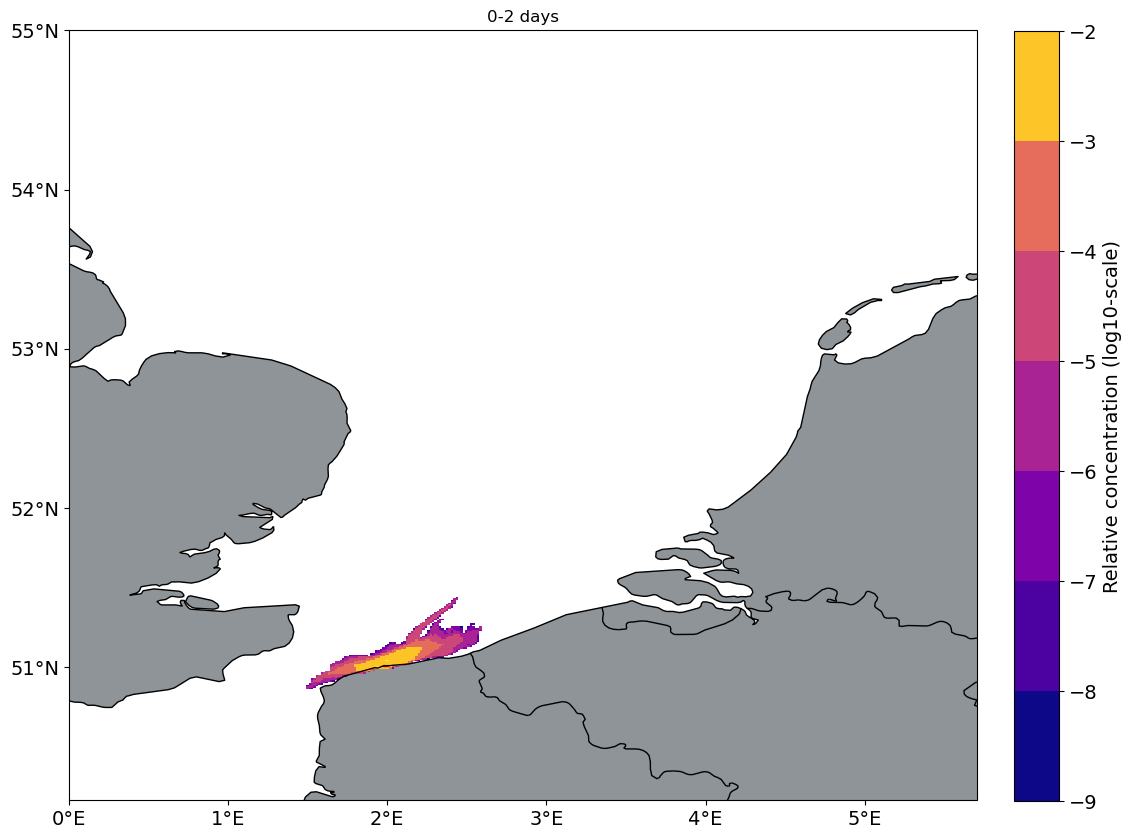

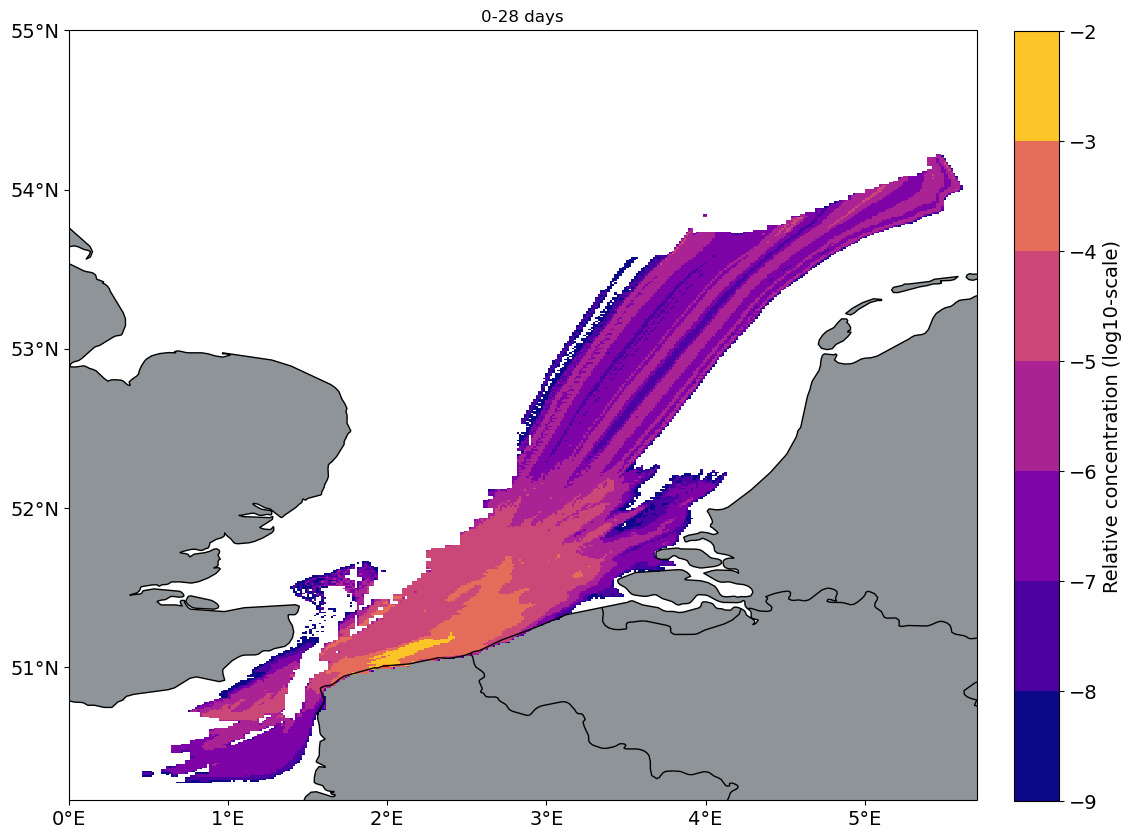

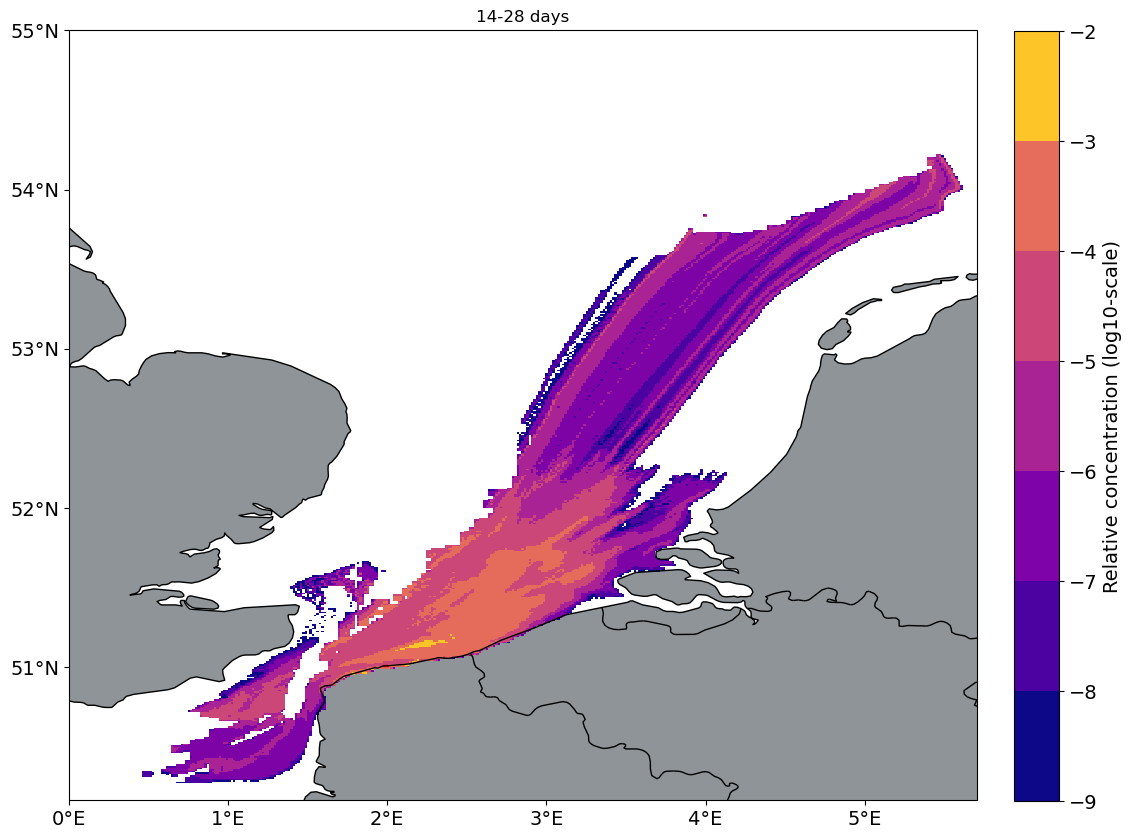

In [20]:
%%time

levels = [-9,-8,-7,-6,-5,-4,-3,-2]
cmap1 = plt.get_cmap('plasma', len(levels) + 1)
norm = BoundaryNorm(levels, len(levels))

test_datasets = xr.open_dataset(f'/gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/revision_heatmaps/FR_0083_data_RT-1.nc')

for i in tqdm(range(3),desc="obs"): # show the spread area for each period scenario
    ds = xr.open_dataset(f'/gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/revision_heatmaps/FR_0083_data_RT-{i}.nc')

    lon_min = ds.lon.min().persist().data[()]
    lon_max = ds.lon.max().persist().data[()]
    lat_min = ds.lat.min().persist().data[()]
    lat_max = ds.lat.max().persist().data[()]
    
    dlon = 0.015
    dlat = 0.01

    lons = np.arange(lon_min - dlon, lon_max + 2 * dlon, dlon)
    lats = np.arange(lat_min - dlat, lat_max + 2 * dlat, dlat)
    
    # create heatmap
    heat_map = xhist(ds.lon, ds.lat, bins=[lons, lats], dim=["traj", ])
    heat_map = heat_map.where(heat_map > 0).sum(dim='obs') #sum over
    
    fig, ax = plt.subplots(figsize=(15, 10), subplot_kw=dict(projection=ccrs.PlateCarree()))
    ax.set_extent([test_datasets["lon"].min()-0.1,test_datasets["lon"].max()+0.1,
               test_datasets["lat"].min()-0.1,test_datasets["lat"].max()+0.1], crs=ccrs.PlateCarree())
    img_extent = (heat_map["lon_bin"].min(), heat_map["lon_bin"].max(), heat_map["lat_bin"].min(), heat_map["lat_bin"].max())    
    heat2=(heat_map.where(heat_map > 0).fillna(0).T/ heat_map.values.sum())
    im=ax.imshow(np.log10(heat2.where(heat2>0)),
                 cmap=cmap1, norm=norm,extent=img_extent, origin='lower', interpolation='nearest')

    cbar_axim = fig.add_axes([0.84, 0.109, 0.03, 0.77])
    cbar=fig.colorbar(im, cax=cbar_axim,
                  orientation='vertical', ticks=levels)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(r'Relative concentration (log10-scale)', fontsize=14)
    #cbar.set_ticklabels([-9,-8,-7,-6,-5,-4,-3])

    ax.coastlines(resolution='10m')
    ax.add_feature(cf.BORDERS)
    ax.add_feature(cf.LAND, facecolor='#8e9497ff')
    ax.add_patch(Rectangle((1.991481085-dlon, 51.0044913), 2*dlon, dlat,color='red'))
    ax.set_title(obs_periods[i])
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_xticklabels(['0°E','1°E','2°E','3°E','4°E','5°E'],fontsize=14)
    ax.set_yticks([51,52,53,54,55])
    ax.set_yticklabels(['51°N','52°N','53°N','54°N','55°N'],fontsize=14)
#    fig.savefig(f'/gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/revision_figures/FR_0083_100%heatmap_40m_RT-{i}.svg', bbox_inches='tight')

---

### All stations overview

In [21]:
stationslonlat = pd.read_csv(release_stations_file, delimiter="\t")

In [22]:
area_colors = ['#ff00ff', '#000080', '#a0522d', '#afeeee', '#ff0000', '#ffdead',
               '#b03060', '#483d8b', '#1e90ff', '#f08080', '#008b8b', '#adff2f',
               '#8a2be2', '#ff1493', '#00ff00', '#ff6347', '#7fffd4', '#32cd32',
               '#f4a460', '#228b22', '#d8bfd8', '#808080', '#0000ff', '#ff8c00',
               '#7b68ee', '#8fbc8f', '#4682b4', '#da70d6', '#00fa9a', '#ffd700',
               '#7f007f', '#556b2f']

100%|███████████████████████████████████████████| 32/32 [00:01<00:00, 29.22it/s]


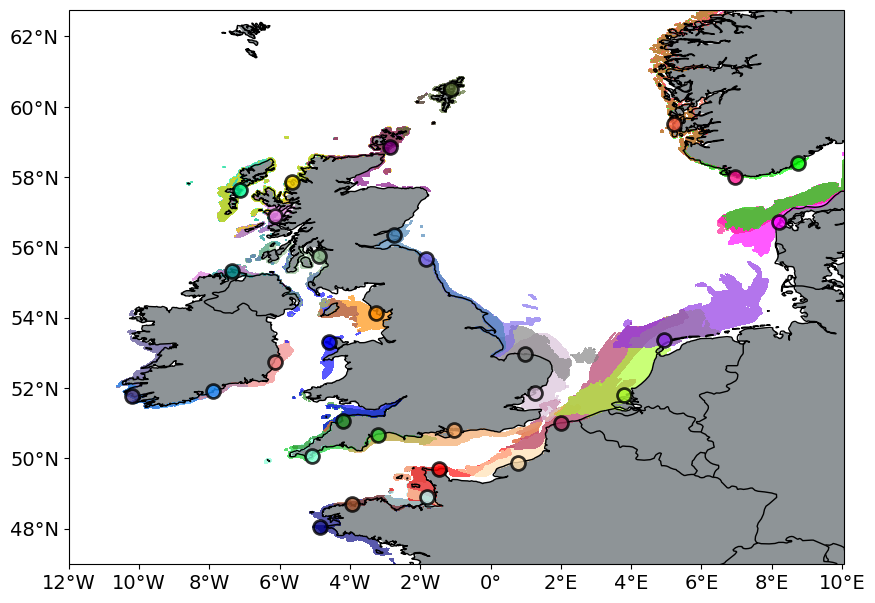

In [23]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=ccrs.PlateCarree()))

for i, station in enumerate(tqdm(stations)):
    try:        
        heat_map = xr.open_dataset(f'/gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/revision_heatmaps/{station}_heatmap.nc')

        cr=ax.contourf(heat_map.lon_bin, heat_map.lat_bin, heat_map.histogram_lon_lat.fillna(0).T,
                       colors=area_colors[i], alpha = 0.65, levels=[1,heat_map.histogram_lon_lat.max()]) 
        ax.scatter(stationslonlat['lon'][i],stationslonlat['lat'][i],color=area_colors[i],s=100,edgecolors='black',marker='o',zorder=2, linewidths=2, alpha = 0.8)
        
    # try and except to ensure the entire loop runs... in case there is data missing
    except Exception as e:
        print(f"Error processing at station {station}: {str(e)}")
        
ax.coastlines(resolution='10m')
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.LAND, facecolor='#8e9497ff')
#ax.add_patch(Rectangle((1.991481085-0.03, 51.0044913), 2*0.03, 0.05,color='red'))
ax.set_xticks(np.arange(-12,11,2))
ax.set_xticklabels(['12°W','10°W','8°W','6°W','4°W','2°W','0°','2°E',
                    '4°E','6°E','8°E','10°E'],fontsize=14)
ax.set_yticks(np.arange(48,63,2))
ax.set_yticklabels(['48°N','50°N','52°N','54°N','56°N','58°N','60°N','62°N'],fontsize=14)
plt.show()
# fig.savefig('/gxfs_work/geomar/smomw523/2022_north-sea_oysters/output_data/revision_figures/overview_all.svg',bbox_inches='tight')

---